## Taking a look at the Enron unlabeled data

code borrowed from :
https://github.com/shoreason/enron-topic-modeling/blob/master/enron_lda.ipynb

In [1]:
import numpy as np
import pandas as pd
import vocab as vocabulary
import collections
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
# from wordcloud import WordCloud ,STOPWORDS
from collections import defaultdict

In [2]:
import glob
import fileinput
import shutil
import os,sys,inspect
import time
# import markdown
import json
import requests
import warnings
import re


In [3]:
from __future__ import unicode_literals, print_function
from spacy.lang.en import English



from bertmodel.pybert.io.data_transformer import DataTransformer
from pytorch_pretrained_bert.tokenization import BertTokenizer
from bertmodel.pybert.config.basic_config import configs as config

In [47]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# !pip3 install langdetect
# from langdetect import detect

In [5]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import googleapi

In [6]:
# PerspectiveAPI = googleapi.GOOGLEAPI

In [7]:
datadir = "/data/SuperMod/emails.csv"

In [8]:
enrondata = pd.read_csv(datadir)

In [9]:
enrondata.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


## Parse email

In [10]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [11]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from')
    }

In [12]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [13]:
email_df = pd.DataFrame(parse_into_emails(enrondata.message))
print(email_df.head())

                                                body                       to  \
0                               Here is our forecast     tim.belden@enron.com   
1  Traveling to have a business meeting takes the...  john.lavorato@enron.com   
2                     test successful.  way to go!!!   leah.arsdall@enron.com   
3  Randy,Can you send me a schedule of the salary...    randall.gay@enron.com   
4                                                        greg.piper@enron.com   

                     from_  
0  phillip.allen@enron.com  
1  phillip.allen@enron.com  
2  phillip.allen@enron.com  
3  phillip.allen@enron.com  
4  phillip.allen@enron.com  


## Add Perspective score: toxiciy only

In [14]:
email_df.body

0                                      Here is our forecast
1         Traveling to have a business meeting takes the...
2                            test successful.  way to go!!!
3         Randy,Can you send me a schedule of the salary...
4                                                          
5         Greg,How about either next Tuesday or Thursday...
6         Phillip Allen (pallen@enron.com)Mike Grigsby (...
7                                                          
8         I don't think these are required by the ISP2. ...
9         ---------------------- Forwarded by Phillip K ...
10        Mr. Buckner,For delivered gas behind San Diego...
11        Lucy,Open them and save in the rentroll folder...
12        ---------------------- Forwarded by Phillip K ...
13        ---------------------- Forwarded by Phillip K ...
14        Dave,Here are the names of the west desk membe...
15                          Paula,35 million is finePhillip
16        ---------------------- Forward

The following section adds perspective score does not have to run every time

In [15]:
# # obtained from https://www.kaggle.com/tarunpaparaju/jigsaw-competition-google-perspective-api
# # allowed test types
# allowed = ["TOXICITY",
#            "SEVERE_TOXICITY",
#            "TOXICITY_FAST",
#            "ATTACK_ON_AUTHOR",
#            "ATTACK_ON_COMMENTER",
#            "INCOHERENT",
#            "INFLAMMATORY",
#            "OBSCENE",
#            "OFF_TOPIC",
#            "UNSUBSTANTIAL",
#            "LIKELY_TO_REJECT"]

# class Perspective(object):

#     base_url = "https://commentanalyzer.googleapis.com/v1alpha1"

#     def __init__(self, key):
#         self.key = key

#     def score(self, text, tests=["TOXICITY"], context=None, languages=None, do_not_store=False, token=None, text_type=None):
#         # data validation
#         # make sure it's a valid test
#         # TODO: see if an endpoint that has valid types exists
#         if isinstance(tests, str):
#             tests = [tests]
#         if not isinstance(tests, (list, dict)) or tests is None:
#             raise ValueError("Invalid list/dictionary provided for tests")
#         if isinstance(tests, list):
#             new_data = {}
#             for test in tests:
#                 new_data[test] = {}
#             tests = new_data
#         if text_type:
#             if text_type.lower() == "html":
#                 text = remove_html(text)
#             elif text_type.lower() == "md":
#                 text = remove_html(text, md=True)
#             else:
#                 raise ValueError("{0} is not a valid text_type. Valid options are 'html' or 'md'".format(str(text_type)))

#         for test in tests.keys():
#             if test not in allowed:
#                 warnings.warn("{0} might not be accepted as a valid test.".format(str(test)))
#             for key in tests[test].keys():
#                 if key not in ["scoreType", "scoreThreshhold"]:
#                     raise ValueError("{0} is not a valid sub-property for {1}".format(key, test))

#         # The API will only grade text less than 3k characters long
#         if len(text) > 3000:
#             # TODO: allow disassembly/reassembly of >3000char comments
#             warnings.warn("Perspective only allows 3000 character strings. Only the first 3000 characters will be sent for processing")
#             text = text[:3000]
#         new_langs = []
#         if languages:
#             for language in languages:
#                 language = language.lower()
#                 if validate_language(language):
#                     new_langs.append(language)

#         # packaging data
#         url = Perspective.base_url + "/comments:analyze"
#         querystring = {"key": self.key}
#         payload_data = {"comment": {"text": text}, "requestedAttributes": {}}
#         for test in tests.keys():
#             payload_data["requestedAttributes"][test] = tests[test]
#         if new_langs != None:
#             payload_data["languages"] = new_langs
#         if do_not_store:
#             payload_data["doNotStore"] = do_not_store
#         payload = json.dumps(payload_data)
#         headers = {'content-type': "application/json"}
#         response = requests.post(url,
#                             data=payload,
#                             headers=headers,
#                             params=querystring)
#         data = response.json()
#         if "error" in data.keys():
#             raise PerspectiveAPIException(data["error"]["message"])
#         c = Comment(text, [], token)
#         base = data["attributeScores"]
#         for test in tests.keys():
#             score = base[test]["summaryScore"]["value"]
#             score_type = base[test]["summaryScore"]["type"]
#             a = Attribute(test, [], score, score_type)
#             for span in base[test]["spanScores"]:
#                 beginning = span["begin"]
#                 end = span["end"]
#                 score = span["score"]["value"]
#                 score_type = span["score"]["type"]
#                 s = Span(beginning, end, score, score_type, c)
#                 a.spans.append(s)
#             c.attributes.append(a)
#         return c

# class Comment(object):
#     def __init__(self, text, attributes, token):
#         self.text = text
#         self.attributes = attributes
#         self.token = token

#     def __getitem__(self, key):
#         if key.upper() not in allowed:
#             raise ValueError("value {0} does not exist".format(key))
#         for attr in self.attributes:
#             if attr.name.lower() == key.lower():
#                 return attr
#         raise ValueError("value {0} not found".format(key))

#     def __str__(self):
#         return self.text

#     def __repr__(self):
#         count = 0
#         num = 0
#         for attr in self.attributes:
#             count += attr.score
#             num += 1
#         return "<({0}) {1}>".format(str(count/num), self.text)

#     def __iter__(self):
#         return iter(self.attributes)

#     def __len__(self):
#         return len(self.text)

# class Attribute(object):
#     def __init__(self, name, spans, score, score_type):
#         self.name = name
#         self.spans = spans
#         self.score = score
#         self.score_type = score_type

#     def __getitem__(self, index):
#         return self.spans[index]

#     def __iter__(self):
#         return iter(self.spans)

# class Span(object):
#     def __init__(self, begin, end, score, score_type, comment):
#         self.begin = begin
#         self.end = end
#         self.score = score
#         self.score_type = score_type
#         self.comment = comment

#     def __str__(self):
#         return self.comment.text[self.begin:self.end]

#     def __repr__(self):
#         return "<({0}) {1}>".format(self.score, self.comment.text[self.begin:self.end])

# class PerspectiveAPIException(Exception):
#     pass

In [16]:

# client = Perspective(PerspectiveAPI)

In [17]:

# emails = email_df['body']


In [18]:
# emails[:5]

In [19]:
# toxicity_scores = []


# start = time.time()
# print("                         EXAMPLE WORKING OF PERSPECTIVE API                          ")
# print("                         ----------------------------------                          ")
# print("")
# for i, email in enumerate(emails[:10]):
#     if email == '':
#         continue

#     current = time.time()
#     time.sleep((i + 1) - (current - start)) # limit API calls to 1 per second
#     toxicity = client.score(email, tests=["TOXICITY"])

#     toxicity_scores.append(toxicity["TOXICITY"].score)

#     if i <= 50:
#         print("email :\n" + email)
#         print("")
#         print("TOXICITY SCORE : " + str(toxicity["TOXICITY"].score) )

#         print(("*********************************************************************"+\
#                "***********************").replace('*', '-'))
#         print("")

### add score to all emails

In [20]:
# def get_perspective_score(email_list):
#     start = time.time()
#     toxicity_scores = []
    
#     for i, email in enumerate(email_list):
        
#         if email == '' or not re.search('[a-zA-Z]+', email) or  detect(email) != 'en' :
#             # Perspective only works with english. Remove empty strings and non English emails
#             toxicity_scores.append(0)
#         else:

#             current = time.time()
#             time.sleep((i + 1) - (current - start)) # limit API calls to 1 per second
#             toxicity = client.score(email, tests=["TOXICITY"])

#             toxicity_scores.append(toxicity["TOXICITY"].score)
#         print(i)
            

#     return toxicity_scores


In [21]:
# print (re.search('[a-zA-Z]+','2000-1969=31'))

In [22]:
# emails[194:197]

In [23]:
# for i, email in enumerate(emails):
#     print(i)
#     if email != '':
#         detect(email) != 'en'

In [24]:

# toxicity_scores_all = get_perspective_score(emails)

In [25]:
## total count
## 517398

In [26]:
# print(email_df.iloc[13,0])

In [27]:
# print(enrondata.iloc[13,1])

In [28]:
# email_df.body.iloc

## Look at length of email, and how many are forwarded

In [29]:
email_body = email_df.body

In [30]:
email_body[517373]

'yes-----Original Message-----This is the first that I have heard of this.  Something for Mike to look at ?Mark-----Original Message-----'

In [31]:
toxic_pattern = 'i thought we would win.  they suck.  i hate football.'
# 'Smug, paranoid, unhappy mother fucker.'

In [32]:
for ind, email in enumerate (email_body):
    if toxic_pattern in email:
        print(email)
        print(ind)


yeah right.  you probably watched football all day yesterday.  you lovefootball.-----Original Message-----i thought we would win.  they suck.  i hate football.-----Original Message-----did you really think you were going to win?  aren't ya'll pretty bad?  ijust went out sat. night and then went to beaumont sun. b/c it was mygrandmother's birthday.-----Original Message-----everyone was pissed cause we lost.  what did you do this weekend?-----Original Message-----why would you come home that night just b/c they lost?-----Original Message-----it was ok.  we went to the lsu game and lsu lost so we came home thatnight.  what did you do this weekend?-----Original Message-----i didn't get your message until late last night.  what's goingon?didyouhave a good weekend**********************************************************************This e-mail is the property of Enron Corp. and/or its relevantaffiliateandmay contain confidential and privileged material for the sole use oftheintended recipien

In [33]:
email_body[516592]

'Robert, Here are the two messages from "Jeff Lawson" and the response I got from Jeff Sprecher at the ICE regarding my complaint. I appreciate your handling this matter.Andy--------- Inline attachment follows ---------HA HA HA YOU STUPID, ARROGANT FUCK__________________________________________________Do You Yahoo!?Buy the perfect holiday gifts at Yahoo! Shopping.--------- Inline attachment follows ---------Fuck you, you piece of shit.  I can\'t wait to see yougo down with the ship like all the other vermin.Smug, paranoid, unhappy mother fucker.Eat shit.__________________________________________________Do You Yahoo!?Yahoo! GeoCities - quick and easy web site hosting, just $8.95/month.--------- Inline attachment follows ---------Andy,We pulled the log ... found the guy ... and told him to knock it off.Please let me know if there is a repeat performance.Best regards, Jeff'

In [34]:
test_email = email_body[12]

In [35]:
test_org_msg = email_body[275868]

### In other words, the forwarded messages very likely will also appear in the data
So we can't split the forwarded emails into new emails, will create duplicates

## Next, we count how many sentences in entire email

In [36]:
tokenizer = BertTokenizer(vocab_file=config['pretrained']['bert']['vocab_path'],
                          do_lower_case=config['train']['do_lower_case'])

In [37]:
nlp = English ()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [38]:
doc = nlp ('I think this would work? what do you think... I hope it . does.')

In [39]:
print(len(list(doc.sents)))

3


In [40]:
for i, sent in enumerate(doc.sents):
    print(sent.text)
    print(i)

I think this would work?
0
what do you think... I hope it .
1
does.
2


In [122]:
def break_into_lines (email):
    
    nlp = English ()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    try:
        doc = nlp (email)
        return list(doc.sents)
    except:
        return []

In [70]:
email_sentence_cnt = email_body[:5].map(break_into_lines)
email_sentence_cnt

0                          [(Here, is, our, forecast)]
1    [(Traveling, to, have, a, business, meeting, t...
2    [(test, successful, .), ( , way, to, go, !, !,...
3    [(Randy, ,, Can, you, send, me, a, schedule, o...
4                                                   []
Name: body, dtype: object

In [71]:
num_of_lines(num_of_lines(email_body[0]))

0

In [77]:
email_body[275868].split("---------------------- Forwarded by ")[0].split("-----Original Message")[0]

'yeah right.  you probably watched football all day yesterday.  you lovefootball.'

In [76]:
num_of_lines(email_body[275868].split("---------------------- Forwarded by ")[0].split("-----Original Message")[0])

[yeah right.,
  you probably watched football all day yesterday.,
  you lovefootball.]

In [65]:
email_sentence_cnt

0                          [(Here, is, our, forecast)]
1    [(Traveling, to, have, a, business, meeting, t...
2    [(test, successful, .), ( , way, to, go, !, !,...
3    [(Randy, ,, Can, you, send, me, a, schedule, o...
4                                                   []
Name: body, dtype: object

In [51]:
num_of_lines(test_email)

42

In [58]:
nlp = English ()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
doc = nlp (test_email)
list(doc.sents)

[---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/09/2000Richard BurchfieldPhillip,Below is the issues & to do list as we go forward with documenting therequirements for consolidated physical/financial positions and transporttrade capture.,
 What we need to focus on is the first bullet in Allan's list;the need for a single set of requirements.,
 Although the meeting with Keith,on Wednesday,  was informative the solution of creating a infinitely dynamicconsolidated position screen, will be extremely difficult and timeconsuming.,
  Throughout the meeting on Wednesday, Keith alluded to theinability to get consensus amongst the traders on the presentation of theconsolidated position, so the solution was to make it so that a trader canarrange the position screen to their liking (much like Excel).,
 What needs tohappen on Monday from 3 - 5 is a effort to design a desired layout for theconsolidated position screen, this is critical.,
 This does not excludebuilding a capabilit

In [78]:
email_sentence_cnt

0     1
1    10
2     2
3     2
4     0
5     1
6     1
7     0
8     2
9    15
Name: body, dtype: int64

In [80]:
email_body[7]

''

In [ ]:
# email_body[517374]

In [129]:
# test_email

In [130]:
# print(tokenizer.tokenize(test_email))

In [123]:
def avg_sent_len_f (sent):
    if sent == []:
        return 0
    else:
        return np.mean([len(s) for s in sent])
    
email_test = email_df[:500].copy()
email_body_test = email_body[:500]
email_sentence = email_body_test.map(break_into_lines)
email_forward_cnt = email_body_test.map(lambda x: len(x.split("---------------------- Forwarded by "))-1)
email_reply_cnt = email_body_test.map(lambda x: len(x.split("-----Original Message"))-1)
new_message_only = email_body_test.map(lambda x: x.split("---------------------- Forwarded by ")[0].split("-----Original Message")[0].split("--------- Inline attachment follows")[0])
new_message_sentence = new_message_only.map(break_into_lines)
email_sentence_cnt = email_sentence.map(lambda x: len(x))
new_message_sentence_cnt = new_message_sentence.map(lambda x: len(x))
avg_sent_len = email_sentence.map(avg_sent_len_f)
avg_sent_len_newe = new_message_sentence.map(avg_sent_len_f)

email_test["email_sentence"] = email_sentence
email_test["email_forward_cnt"] = email_forward_cnt
email_test["email_reply_cnt"] =  email_reply_cnt
email_test["new_message_only"] =  new_message_only
email_test["new_message_sentence"] = new_message_sentence
email_test["email_sentence_cnt"] =  email_sentence_cnt
email_test["new_message_sentence_cnt"] = new_message_sentence_cnt 
email_test["avg_sent_len"] =  avg_sent_len
email_test["avg_sent_len_newe"] = avg_sent_len_newe 

In [124]:
figureout = email_body[60:70].map(lambda x: x.split("---------------------- Forwarded by ")[0].split("-----Original Message")[0].split("--------- Inline attachment follows")[0])

In [125]:
figureout.map(break_into_lines)

60    [(Larry, ,, Just, a, note, to, touch, base, on...
61                                                   []
62                                           [(Ina, ,)]
63    [(jay.reitmeyer@enron.com, ,, frank.ermis@enro...
64    [(Ina, ,, Can, you, pull, Tori, K., 's, and, M...
65                             [(resumes, of, whom, ?)]
66                                                   []
67                                                   []
68                                                   []
69    [(Richard, ,, Compare, your, california, produ...
Name: body, dtype: object

In [126]:
email_test.to_csv (r'/data/SuperMod/test_email.csv', index = None, header=True)

## Plot sentence count distribution for sample set

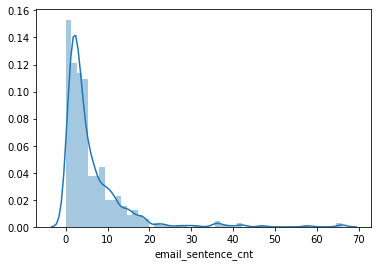

In [127]:
sns.distplot(email_test.email_sentence_cnt)

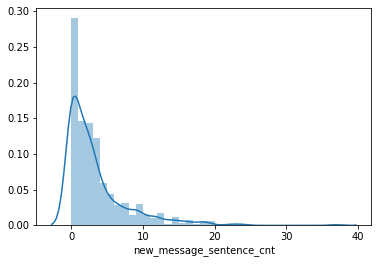

In [128]:
sns.distplot(email_test.new_message_sentence_cnt)

In [134]:
print("the total number of messages with forward and reply",\
      sum(email_forward_cnt) +  sum(email_reply_cnt))

the total number of messages with forward and reply 205


In [132]:
print("the avg number of sentences", np.mean(email_test.email_sentence_cnt))

the avg number of sentences 6.108


In [133]:
print("the avg number of sentences", np.mean(email_test.new_message_sentence_cnt))

the avg number of sentences 3.35


## Average # of sentence

If we look at the entire email, it has about 6 counts.  
IF we only look at the new emails, the email lenght is about 3.  
Also, for many new sentences, there are no new words  
So those emails would lowere the sentence counts  

In [34]:
# re.search(forward_pattern, test_email)

<_sre.SRE_Match object; span=(0, 32), match='---------------------- Forwarded'>

In [ ]:
print (re.search('[a-zA-Z]+','2000-1969=31'))

In [32]:

email_body[:20]

0                                  Here is our forecast
1     Traveling to have a business meeting takes the...
2                        test successful.  way to go!!!
3     Randy,Can you send me a schedule of the salary...
4                                                      
5     Greg,How about either next Tuesday or Thursday...
6     Phillip Allen (pallen@enron.com)Mike Grigsby (...
7                                                      
8     I don't think these are required by the ISP2. ...
9     ---------------------- Forwarded by Phillip K ...
10    Mr. Buckner,For delivered gas behind San Diego...
11    Lucy,Open them and save in the rentroll folder...
12    ---------------------- Forwarded by Phillip K ...
13    ---------------------- Forwarded by Phillip K ...
14    Dave,Here are the names of the west desk membe...
15                      Paula,35 million is finePhillip
16    ---------------------- Forwarded by Phillip K ...
17    Tim,mike grigsby is having problems with a

In [22]:
email_body[18]

"---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/03/2000Please respond to <cbpres@austin.rr.com>WestgateEnclosed are demographics on the Westgate site from Investor's Alliance.Investor's Alliance says that these demographics are similar to the packageon San Marcos that you received earlier.If there are any other questions or information requirements, let me know.Then, let me know your interest level in the Westgate project?San MarcosThe property across the street from the Sagewood units in San Marcos is forsale and approved for 134 units.  The land is selling for $2.50 per squarefoot as it is one of only two remaining approved multifamily parcels in WestSan Marcos, which now has a moratorium on development.Several new studies we have looked at show that the rents for our duplexesand for these new units are going to be significantly higher, roughly $1.25per square foot if leased for the entire unit on a 12-month lease and$1.30-$1.40 psf if leased on a 12-month term, bu

'yes-----Original Message-----This is the first that I have heard of this.  Something for Mike to look at ?Mark-----Original Message-----'